In [150]:
from pathlib import Path
import sys

print("CWD:", Path.cwd())

PROJECT_ROOT = Path.cwd().parent     
SRC_DIR = PROJECT_ROOT / "src"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC_DIR exists:", SRC_DIR.exists())

if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

print("dsvm in sys.path now:", any("src" in p and "dsvm-dtw" in p for p in sys.path))

CWD: c:\Users\siam2\Desktop\dsvm-dtw\experiments
PROJECT_ROOT: c:\Users\siam2\Desktop\dsvm-dtw
SRC_DIR exists: True
dsvm in sys.path now: True


In [151]:
# Phase I: Bootstrap 기반 control limit 설계
# dsvm_phase1_control_limit.ipynb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dsvm.arl_mcc import estimate_arl_for_h_mcc

In [152]:
# 프로젝트 루트 및 결과 디렉토리 설정
THIS_NOTEBOOK = Path().resolve()
PROJECT_ROOT = THIS_NOTEBOOK.parent   # dsvm-dtw/
RESULTS_DIR = PROJECT_ROOT / "results"
TABLES_DIR = RESULTS_DIR / "tables"
CONTROL_DIR = RESULTS_DIR / "control_limits"

TABLES_DIR.mkdir(parents=True, exist_ok=True)
CONTROL_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("RESULTS_DIR :", RESULTS_DIR)
print("TABLES_DIR  :", TABLES_DIR)
print("CONTROL_DIR :", CONTROL_DIR)

# 데이터셋 / 실험 설정
dataset = "ECG5000"
stream = "train_incontrol"
mode = "ecd"         
data_version = "original"
seed = 10
m = 100               
target_arl0 = 20

# 병합이 완료된 bootstrap p_swk 파일 범위
rep_start = 0
rep_end = 999   # 예: 0~199 → rep_0 ~ rep_199

PROJECT_ROOT: C:\Users\siam2\Desktop\dsvm-dtw
RESULTS_DIR : C:\Users\siam2\Desktop\dsvm-dtw\results
TABLES_DIR  : C:\Users\siam2\Desktop\dsvm-dtw\results\tables
CONTROL_DIR : C:\Users\siam2\Desktop\dsvm-dtw\results\control_limits


In [153]:
# Phase I 데이터프레임 불러오기
file_name = (
    f"{dataset}_{stream}_p_swk_matrix_{mode}_{data_version}"
    f"({rep_start}~{rep_end})_bootstrap_seed{seed}_m={m}.csv"
)
file_path = TABLES_DIR / file_name

print("읽을 파일명:", file_name)
print("전체 경로  :", file_path)

# 't'를 index로 복구
df_pswk = pd.read_csv(file_path, index_col=0)
print("df_pswk.shape:", df_pswk.shape)
df_pswk.head()

읽을 파일명: ECG5000_train_incontrol_p_swk_matrix_ecd_original(0~999)_bootstrap_seed10_m=100.csv
전체 경로  : C:\Users\siam2\Desktop\dsvm-dtw\results\tables\ECG5000_train_incontrol_p_swk_matrix_ecd_original(0~999)_bootstrap_seed10_m=100.csv
df_pswk.shape: (100, 1000)


,rep_0,rep_1,rep_2,rep_3,rep_4,rep_5,rep_6,rep_7,rep_8,rep_9,...,rep_990,rep_991,rep_992,rep_993,rep_994,rep_995,rep_996,rep_997,rep_998,rep_999
t,,,,,,,,,,,,,,,,,,,,,
0,0.335768,0.334756,0.297072,0.315020,0.304485,0.326090,0.323241,0.319152,0.370248,0.333805,...,0.328654,0.305365,0.331165,0.327759,0.302023,0.333255,0.325186,0.318110,0.319285,0.308026
1,0.319325,0.319286,0.340146,0.381371,0.331759,0.339270,0.329291,0.332822,0.353121,0.353173,...,0.323116,0.304177,0.296132,0.352185,0.313863,0.319431,0.332059,0.301808,0.315296,0.292678
2,0.314829,0.319747,0.339204,0.317412,0.308548,0.314776,0.311097,0.311516,0.333740,0.375034,...,0.295394,0.327646,0.319574,0.316516,0.355113,0.334037,0.312875,0.349467,0.312417,0.387332
3,0.336555,0.300408,0.348573,0.335262,0.332492,0.333891,0.319276,0.343124,0.326873,0.340749,...,0.332361,0.339066,0.299042,0.309923,0.319858,0.353700,0.318749,0.318834,0.296438,0.325671
4,0.319871,0.334071,0.323916,0.331978,0.298899,0.358140,0.342734,0.326506,0.314295,0.343888,...,0.367826,0.311862,0.357875,0.349221,0.354359,0.409370,0.319454,0.347892,0.309208,0.317076


In [154]:
p_swk_mat = df_pswk.values  # shape (m, outer_reps)

print("p_swk min :", p_swk_mat.min())
print("p_swk max :", p_swk_mat.max())

# 아주 넓은 구간에서 coarase grid
h_grid_coarse = np.linspace(p_swk_mat.min(), p_swk_mat.max(), 20)

rows = []
for h in h_grid_coarse:
    est = estimate_arl_for_h_mcc(h=h, p_swk_mat=p_swk_mat, m=m)
    rows.append({"h": h, "ARL0": est["arl"]})

df_scan = pd.DataFrame(rows)
df_scan


p_swk min : 0.284649928529659
p_swk max : 0.4644252952772176


,h,ARL0
0,0.284650,1.000000
1,0.294112,1.009000
2,0.303574,1.099000
3,0.313036,1.422000
4,0.322497,2.244000
5,0.331959,5.362362
6,0.341421,12.495413
7,0.350883,25.474704
8,0.360345,55.584535
9,0.369807,101.374787


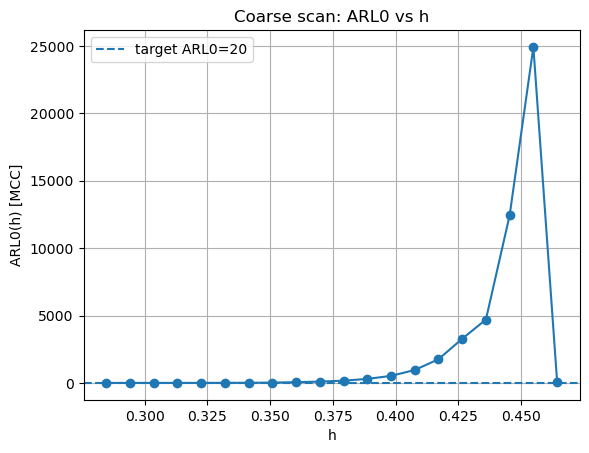

In [155]:
plt.plot(df_scan["h"], df_scan["ARL0"], marker="o")
plt.axhline(target_arl0, linestyle="--", label=f"target ARL0={target_arl0}")
plt.xlabel("h")
plt.ylabel("ARL0(h) [MCC]")
plt.title("Coarse scan: ARL0 vs h")
plt.legend()
plt.grid(True)
plt.show()

In [156]:
# diff = ARL0 - target
df_scan["diff"] = df_scan["ARL0"] - target_arl0
df_scan

,h,ARL0,diff
0,0.284650,1.000000,-19.000000
1,0.294112,1.009000,-18.991000
2,0.303574,1.099000,-18.901000
3,0.313036,1.422000,-18.578000
4,0.322497,2.244000,-17.756000
5,0.331959,5.362362,-14.637638
6,0.341421,12.495413,-7.504587
7,0.350883,25.474704,5.474704
8,0.360345,55.584535,35.584535
9,0.369807,101.374787,81.374787


In [157]:
brackets = []

for i in range(len(df_scan) - 1):
    h1, a1, d1 = df_scan.loc[i, ["h", "ARL0", "diff"]]
    h2, a2, d2 = df_scan.loc[i+1, ["h", "ARL0", "diff"]]

    # sign change 여부 확인
    if d1 == 0:
        brackets.append((h1, h1))
    elif d1 * d2 < 0:
        brackets.append((h1, h2))

brackets


[(0.34142109697625644, 0.35088295838402267)]

In [158]:
if len(brackets) == 0:
    print("경고: coarse grid에서 target ARL0를 가로지르는 구간을 찾지 못했습니다.")
    print("→ h 범위를 넓히거나, coarse grid 개수를 늘려서 다시 확인하는 게 좋습니다.")
    # 그래도 진행하고 싶다면, 그냥 전체 범위에서 best gap를 찾는 fallback을 만들 수도 있음
else:
    h_low, h_high = brackets[0]
    print(f"선택된 브래킷 구간: h_low = {h_low:.6f}, h_high = {h_high:.6f}")


선택된 브래킷 구간: h_low = 0.341421, h_high = 0.350883


In [159]:
target_arl = target_arl0
tolerance = 0.01
max_iter = 50  # coarse 브래킷 안이므로 너무 많이 안 돌려도 됨

lower = h_low
upper = h_high

best_h = None
best_arl = None
best_gap = float('inf')
best_sdrl = None
best_se = None

for _ in range(max_iter):
    mid = (lower + upper) / 2
    res = estimate_arl_for_h_mcc(mid, p_swk_mat, m)
    est_arl = res['arl']
    gap = abs(est_arl - target_arl)

    if gap < best_gap:
        best_gap = gap
        best_h = mid
        best_arl = est_arl
        best_sdrl = res['sdrl']
        best_se = res['se']

    if gap < tolerance:
        break

    # ARL가 target보다 작으면 → threshold가 너무 낮은 것 → 더 크게
    if est_arl < target_arl:
        lower = mid
    else:
        upper = mid

print(f"\n✅ 최적 h ≈ {best_h:.6f}")
print(f"   추정 ARL0(h*) ≈ {best_arl:.3f} (target={target_arl})")
print(f"   SDRL(h*)      ≈ {best_sdrl:.3f}")
print(f"   SE[ARL0(h*)]  ≈ {best_se:.4f}")
print(f"   최종 gap      ≈ {best_gap:.4f}")



✅ 최적 h ≈ 0.347335
   추정 ARL0(h*) ≈ 19.999 (target=20)
   SDRL(h*)      ≈ 31.036
   SE[ARL0(h*)]  ≈ 0.9814
   최종 gap      ≈ 0.0010


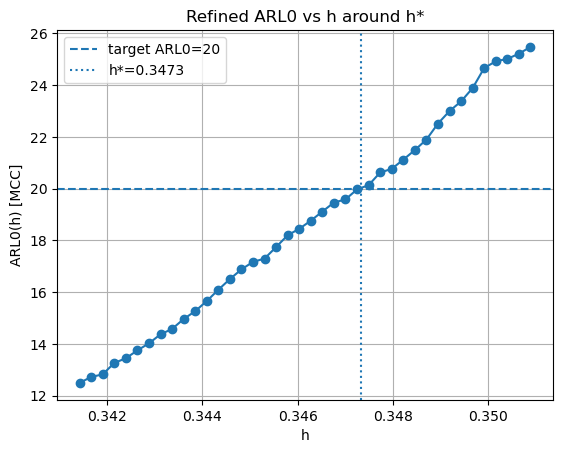

In [160]:
# 브래킷 주변을 조금 더 촘촘하게 보자
h_fine = np.linspace(h_low, h_high, 40)
rows_fine = []
for h in h_fine:
    est = estimate_arl_for_h_mcc(h, p_swk_mat, m)
    rows_fine.append({"h": h, "ARL0": est["arl"]})

df_fine = pd.DataFrame(rows_fine)

plt.plot(df_fine["h"], df_fine["ARL0"], marker="o")
plt.axhline(target_arl0, linestyle="--", label=f"target ARL0={target_arl0}")
plt.axvline(best_h, linestyle=":", label=f"h*={best_h:.4f}")
plt.xlabel("h")
plt.ylabel("ARL0(h) [MCC]")
plt.title("Refined ARL0 vs h around h*")
plt.legend()
plt.grid(True)
plt.show()


In [161]:
import json

#h*만 npy로 저장
h_star = float(best_h)
h_star_path = CONTROL_DIR / f"{dataset}_{stream}_h_star_{mode}_{data_version}_bootstrap_seed{seed}_m={m}.npy"
np.save(h_star_path, np.array([h_star], dtype=float))
print("h* 저장 경로 (npy):", h_star_path)

# 메타정보 json 저장
meta = {
    "dataset": dataset,
    "stream": stream,
    "mode": mode,
    "data_version": data_version,
    "seed": seed,
    "m": m,
    "target_ARL0": target_arl0,
    "h_star": float(best_h),
    "ARL0_h_star": float(best_arl),
    "SDRL_h_star": float(best_sdrl),
    "SE_ARL0_h_star": float(best_se),
    "rep_start": int(rep_start),
    "rep_end": int(rep_end),
}

h_star_json_path = CONTROL_DIR / f"{dataset}_{stream}_h_star_{mode}_{data_version}_bootstrap_seed{seed}_m={m}.json"
with open(h_star_json_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

print("h* 메타정보 json 저장 경로:", h_star_json_path)


h* 저장 경로 (npy): C:\Users\siam2\Desktop\dsvm-dtw\results\control_limits\ECG5000_train_incontrol_h_star_ecd_original_bootstrap_seed10_m=100.npy
h* 메타정보 json 저장 경로: C:\Users\siam2\Desktop\dsvm-dtw\results\control_limits\ECG5000_train_incontrol_h_star_ecd_original_bootstrap_seed10_m=100.json


In [162]:
# 추후 Phase II에서 사용할 때는 
# h_star = float(np.load(h_star_path))